# Background
The objective of this project is to classify the overall sentiment of a tweet's context as neutral, negative, or positive using NLP classifiers. To complete, this project, we are given a dataset of 27,481 tweets, where 22,464 of those tweets were captured as having either a neutral, negative, or positive sentiment. Our goal is to use this training data of ~27.5k tweets to predict the sentiment of the 3,534 tweets in our testing data set.

## Import Libraries
Importing usual data analytics libraries:

In [1]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

Importing text, pre-processing libraries:

In [2]:
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('popular')
from nltk.tokenize import RegexpTokenizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/bethelikejiofor/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/bethelikejiofor/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to
[nltk_data]    |     /Users/bethelikejiofor/nltk_data...
[nltk_data]    |   Package cmudict is already up-to-date!
[nltk_data]    | Downloading package gazetteers to
[nltk_data]    |     /Users/bethelikejiofor/nltk_data...
[nltk_data]    |   Package gazetteers is already up-to-date!
[nltk_data]    | Downloading package genesis to
[nltk_data]    |     /Users/bethelikejiofor/nltk_data...
[nltk_data]    |   Package genesis is already up-to-date!
[nltk_data]    | Downloading package gutenberg to
[nltk_data]    |     /Users/bethelikejiofor

Importing model-building libraries:

In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score

Importing bag of words libraries:

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

Importing word embedding libraries:

In [5]:
import gensim
from gensim.models import Word2Vec

## Loading Dataset

In [6]:
train = pd.read_csv("/Users/bethelikejiofor/Documents/GitHub/ENTITY-Final-Project/Data/train.csv")
train.head()

textID                                               text  \
0  cb774db0d1                I`d have responded, if I were going   
1  549e992a42      Sooo SAD I will miss you here in San Diego!!!   
2  088c60f138                          my boss is bullying me...   
3  9642c003ef                     what interview! leave me alone   
4  358bd9e861   Sons of ****, why couldn`t they put them on t...   

                         selected_text sentiment  
0  I`d have responded, if I were going   neutral  
1                             Sooo SAD  negative  
2                          bullying me  negative  
3                       leave me alone  negative  
4                        Sons of ****,  negative

In [25]:
test = pd.read_csv("/Users/bethelikejiofor/Documents/GitHub/ENTITY-Final-Project/Data/test.csv")
test.head()

textID                                               text sentiment
0  f87dea47db  Last session of the day  http://twitpic.com/67ezh   neutral
1  96d74cb729   Shanghai is also really exciting (precisely -...  positive
2  eee518ae67  Recession hit Veronique Branquinho, she has to...  negative
3  01082688c6                                        happy bday!  positive
4  33987a8ee5             http://twitpic.com/4w75p - I like it!!  positive

## Exploratory Data Analysis

### Sentiment Distribution
The dataset is slightly imbalanced. There are more neutral sentiment tweets (11,118) than there are positive (8,582) or negative (7,781). However, the imbalance is not too much that there needs to be a data-balancing technique introduced.

/usr/local/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:ylabel='sentiment'>

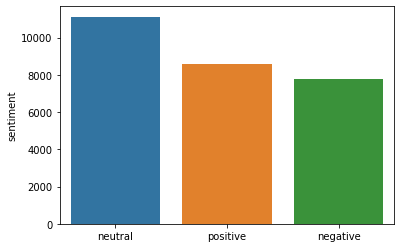

In [7]:
x = train['sentiment'].value_counts()
sns.barplot(x.index, x)

In [8]:
print(x)

neutral     11118
positive     8582
negative     7781
Name: sentiment, dtype: int64


### Missing Values
There is just 1 missing value in the text and selected_text columns. Assuming this is the same row, this row will be removed in the data wrangling step.

In [9]:
train.isna().sum()

textID           0
text             1
selected_text    1
sentiment        0
dtype: int64

### Number of Words in a Tweet

In [10]:
train['word_count'] = train['text'].apply(lambda x: len(str(x).split()))
print(train[train['sentiment']=='neutral']['word_count'].mean())
print(train[train['sentiment']=='positive']['word_count'].mean())
print(train[train['sentiment']=='negative']['word_count'].mean())

12.342867422198237
13.109881146585877
13.473203958360108


Tweets between positive, negative, and neutral sentiments all appear to have around the same number of words. Neutral tweets contain an average of 12.34 words, positive contain an average 13.11 of words, and negative tweets contain an average of 13.47 words.

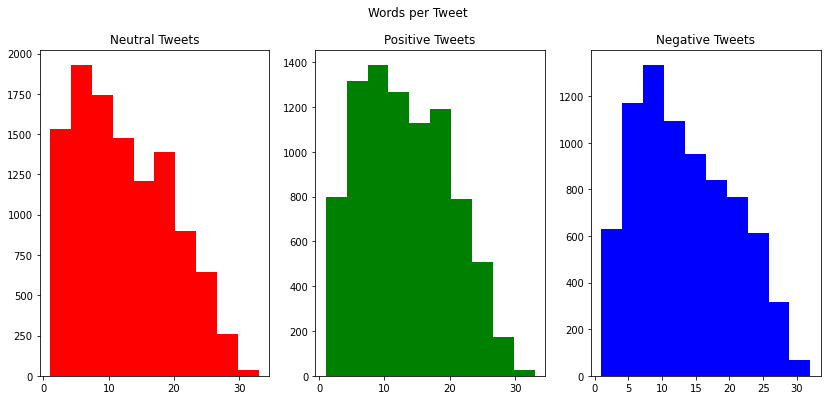

In [11]:
fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(14,6))
train_words=train[train['sentiment']=='neutral']['word_count']
ax1.hist(train_words, color="red")
ax1.set_title('Neutral Tweets')
train_words=train[train['sentiment']=='positive']['word_count']
ax2.hist(train_words, color="green")
ax2.set_title('Positive Tweets')
train_words=train[train['sentiment']=='negative']['word_count']
ax3.hist(train_words, color="blue")
ax3.set_title('Negative Tweets')
fig.suptitle('Words per Tweet')
plt.show()

### Number of Characters in a Tweet
Neutral tweets contain an average of 65.20 characters, positive tweets contain an average of 70.42 characters, and negative tweets contain an average of 70.49 characters.

In [12]:
train['char_count'] = train['text'].apply(lambda x: len(str(x)))
print(train[train['sentiment']=='neutral']['char_count'].mean())
print(train[train['sentiment']=='positive']['char_count'].mean())
print(train[train['sentiment']=='negative']['char_count'].mean())

65.20120525274329
70.41913306921464
70.4881120678576


## Data Wrangling/Text Pre-Processing

### Dropping ID column

In [13]:
train = train[['text','selected_text', 'sentiment']]

### Punctuation Removal Function

In [14]:
def removepunct(text):
    text = re.sub(r'[^\w\s]', '', text)
    return text

### Stopword Removal from Texts Function

In [15]:
def stopword(text):
    a = [i for i in text.split() if i not in stopwords.words('english')]
    return ' '.join(a)

### Lemmatization Function
Lemmatization reduces a word to its base form by getting rid of its suffix

In [16]:
wl = WordNetLemmatizer()
def position(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
    
def lemmatizer(text):
    word_pos_tags = nltk.pos_tag(word_tokenize(text))
    a = [wl.lemmatize(tag[0], position(tag[1])) for idx, tag in enumerate(word_pos_tags)]
    return ' '.join(a)

### Combining Functions for Train & Test Data

In [26]:
def combined(text):
    return lemmatizer(stopword(removepunct(text)))

In [27]:
train['clean'] = train.text.astype(str).str.lower()
test['clean'] = test.text.astype(str).str.lower()

In [28]:
train['clean'] = train['clean'].apply(lambda x: combined(x))
test['clean'] = test['clean'].apply(lambda x: combined(x))

In [21]:
train.head()

text  \
0                I`d have responded, if I were going   
1      Sooo SAD I will miss you here in San Diego!!!   
2                          my boss is bullying me...   
3                     what interview! leave me alone   
4   Sons of ****, why couldn`t they put them on t...   

                         selected_text sentiment  \
0  I`d have responded, if I were going   neutral   
1                             Sooo SAD  negative   
2                          bullying me  negative   
3                       leave me alone  negative   
4                        Sons of ****,  negative   

                                 clean  
0                        id respond go  
1              sooo sad miss san diego  
2                            bos bully  
3                interview leave alone  
4  son couldnt put release already buy

In [29]:
test.head()

textID                                               text sentiment  \
0  f87dea47db  Last session of the day  http://twitpic.com/67ezh   neutral   
1  96d74cb729   Shanghai is also really exciting (precisely -...  positive   
2  eee518ae67  Recession hit Veronique Branquinho, she has to...  negative   
3  01082688c6                                        happy bday!  positive   
4  33987a8ee5             http://twitpic.com/4w75p - I like it!!  positive   

                                               clean  
0               last session day httptwitpiccom67ezh  
1  shanghai also really excite precisely skyscrap...  
2  recession hit veronique branquinho quit compan...  
3                                         happy bday  
4                           httptwitpiccom4w75p like

### Tokenizing the Data

In [22]:
tokenizer = RegexpTokenizer('\w+')
train['tokens'] = train['clean'].apply(tokenizer.tokenize)

In [23]:
train.head()

text  \
0                I`d have responded, if I were going   
1      Sooo SAD I will miss you here in San Diego!!!   
2                          my boss is bullying me...   
3                     what interview! leave me alone   
4   Sons of ****, why couldn`t they put them on t...   

                         selected_text sentiment  \
0  I`d have responded, if I were going   neutral   
1                             Sooo SAD  negative   
2                          bullying me  negative   
3                       leave me alone  negative   
4                        Sons of ****,  negative   

                                 clean  \
0                        id respond go   
1              sooo sad miss san diego   
2                            bos bully   
3                interview leave alone   
4  son couldnt put release already buy   

                                       tokens  
0                           [id, respond, go]  
1               [sooo, sad, miss, san, diego]  
2                                [bos, bully]  
3                   [interview, leave, alone]  
4  [son, couldnt, put, release, already, buy]

## Embedding
Embedding is the process of converting text data to numerical data or vectors.

In [30]:
x_train = train['clean']
y_train = train['sentiment']
x_test = test['clean']
y_test = test['sentiment']

### Word2Vec

In [31]:
x_train_tok= [nltk.word_tokenize(i) for i in x_train]  
x_test_tok= [nltk.word_tokenize(i) for i in x_test]

### Bag of Words

In [48]:
train['clean_text_tok']=[nltk.word_tokenize(i) for i in train['clean']]
model = Word2Vec(train['clean_text_tok'],min_count=1) 

w2v = dict(zip(model.wv.index_to_key, model.wv.vectors)) 


class MeanEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        self.dim = len(next(iter(word2vec.values())))
    def fit(self, X, y):
            return self
    def transform(self, X):
            return np.array([
                np.mean([self.word2vec[w] for w in words if w in self.word2vec]
                    or [np.zeros(self.dim)], axis=0)
                for words in X
            ])

tfidf_vectorizer = TfidfVectorizer(use_idf=True)
x_train_vectors_tfidf = tfidf_vectorizer.fit_transform(x_train)
x_val_vectors_tfidf = tfidf_vectorizer.transform(x_test)
    
model = Word2Vec(train['clean_text_tok'],min_count=1)     
modelw = MeanEmbeddingVectorizer(w2v)

x_train_vectors_w2v = modelw.transform(x_train_tok)
x_val_vectors_w2v = modelw.transform(x_test_tok)

In [49]:
tfidf_vectorizer = TfidfVectorizer(use_idf=True)
x_train_vectors_tfidf = tfidf_vectorizer.fit_transform(x_train) 
x_test_vectors_tfidf = tfidf_vectorizer.transform(x_test)


## Naive Bayes Classifier

In [51]:
nb_tfidf = MultinomialNB()
nb_tfidf.fit(x_train_vectors_tfidf, y_train)  
#Predict y value for test dataset
y_predict = nb_tfidf.predict(x_test_vectors_tfidf)
y_prob = nb_tfidf.predict_proba(x_test_vectors_tfidf)[:,1]
print(classification_report(y_test,y_predict))
print('Confusion Matrix:',confusion_matrix(y_test, y_predict))
 
#fpr, tpr, thresholds = roc_curve(y_test, y_prob)
#roc_auc = auc(fpr, tpr)
#print('AUC:', roc_auc)

              precision    recall  f1-score   support

    negative       0.75      0.42      0.54      1001
     neutral       0.54      0.81      0.65      1430
    positive       0.77      0.56      0.65      1103

    accuracy                           0.62      3534
   macro avg       0.68      0.60      0.61      3534
weighted avg       0.67      0.62      0.62      3534

Confusion Matrix: [[ 418  549   34]
 [ 113 1161  156]
 [  28  454  621]]


In [56]:
#Pre-processing the new dataset
test['clean_text'] = test['text'].apply(lambda x: combined(x)) #preprocess the data
x_test=test['clean_text'] 
#converting words to numerical data using tf-idf
x_vector=tfidf_vectorizer.transform(x_test)
#use the best model to predict 'target' value for the new dataset 
y_predict = nb_tfidf.predict(x_vector)      
y_prob = nb_tfidf.predict_proba(x_vector)[:,1]
test['predict_prob']= y_prob
test['target']= y_predict
final=test[['clean_text','target','sentiment']].reset_index(drop=True)
print(final.head())

                                          clean_text    target sentiment
0               Last session day httptwitpiccom67ezh   neutral   neutral
1  Shanghai also really excite precisely skyscrap...  positive  positive
2  Recession hit Veronique Branquinho quit compan...  negative  negative
3                                         happy bday  positive  positive
4                         httptwitpiccom4w75p I like   neutral  positive
